## Simulator Feature Wishlist:
 * Have the recommender weight unwatched videos higher + have users more willing to watch new videos
 * Give each user a baseline rating: to emulate how some users rate higher than others
 * Add polarity over time graph

## Potential Things to Look Into:
 * Perhaps have a more in-depth matrix of metadata for videos (e.g. vectors indicating authors / directors, run time, etc.)? This could potentially allow for more realistic viewing / recommendation schemes and also allow for more complex user simulated behaviors

In [28]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have a matrix of films, such that each row is a vector holding the metadata for a film. Each film vector is organized as follows: [genre1, genre2, ..., genreN, quality], such that the first NUM_GENRES columns hold how aligned the film is with each genre, and the last column holds the film's quality, which dictates the mean rating for the film. The genre alignment values are all between 0 and 1, and sum to 1.

The user matrix is organized analogously, with each row holding the metdata for the user, in the format: [pref1, pref2, ..., prefN, behavior]. The NUM_GENRES columns hold how much a user likes a particular genre, and the last column holds the user's behavior, which determines how the user will react to recommended videos. Similarly, the preference values are all between 0 and 1, and sum to 1.

In [2]:
# Total number of film genres
NUM_GENRES = 2

# Maximum film rating (e.g. 5 uses the rating scale 0-5)
MAX_RATING = 5

# Higher values = stronger user genre preferences
# Use higher values with higher NUM_GENRES values
# Reasonable values are probably b/w 0.1 and 10
USER_POLARIZATION_STRENGTH = 1
FILM_POLARIZATION_STRENGTH = 1

# A user's "behavior" determines how a user chooses
# which video(s) to watch at each simulation step
# NAMES is a one-word description of each behavior,
# and DISTRIBUTION determines the ratio of behaviors
# among the created users
BEHAVIOR_PROP_IDX = NUM_GENRES
BEHAVIOR_NAMES = ['follower', 'stubborn', 'mixed']
BEHAVIOR_DISTRIBUTION = [1, 1, 1]

# If False, all users watch recommended films with
# probability equal to their compatibility with it
USE_BEHAVIOR = False

# A film's "quality" determines the mean rating
# of the film, and is used as the baseline which
# user preferences modify to get the final rating
QUALITY_PROP_IDX = NUM_GENRES
QUALITY_MIN = MAX_RATING / 4.0
QUALITY_MAX = 3 * MAX_RATING / 4.0

# If False, the average film rating is used as the
# baseline when calculating new ratings instead
USE_QUALITY = True

# How much watched films are penalized over unwatched
# ones when making recommendations, and when the users
# are choosing which videos to watch respectively
# (Effect is multiplicative: should be b/w 0 and 1)
REWATCH_RECOMMENDATION_PENALTY = 0
REWATCH_VIEW_PENALTY = 1

# Validate and standardize the behavior configuration parameters
if len(BEHAVIOR_NAMES) != len(BEHAVIOR_DISTRIBUTION):
    raise ValueError("BEHAVIOR_NAMES and BEHAVIOR_DISTRIBUTION "
            "must have the same length.")
BEHAVIOR_NAMES = np.array(BEHAVIOR_NAMES)
BEHAVIOR_DISTRIBUTION = np.array(BEHAVIOR_DISTRIBUTION) / float(sum(BEHAVIOR_DISTRIBUTION))

In [3]:
def generate_users(number_of_users):
    """
    Generate a user matrix, where each row of the
    matrix stores the properties of a user:
    [genre1_preference, ..., genreN_preference, behavior]
    
    The genre preferences of each user sum to 1.
    behavior will be an integer b/w 0 and num_behaviors
    """
    results = []
    for i in range(number_of_users):
        user_prefs = np.random.dirichlet(
                np.ones(NUM_GENRES)/USER_POLARIZATION_STRENGTH, size=1)[0]
        behavior = np.random.choice(np.arange(len(BEHAVIOR_NAMES)),
                p=BEHAVIOR_DISTRIBUTION)
        user_props = np.append(user_prefs, behavior)
        results.append(user_props)
    return np.array(results)

def generate_films(number_of_films):
    """
    Generate a film matrix, where each row of the
    matrix represents the properties of a film:
    [genre1, ..., genreN, quality]
    
    The genre values of each film sum to 1.
    quality will be b/w QUALITY_MIN and QUALITY_MAX.
    """
    results = []
    for i in range(number_of_films):
        film_genres = np.random.dirichlet(
                np.ones(NUM_GENRES)/FILM_POLARIZATION_STRENGTH, size=1)[0]
        quality = random.uniform(QUALITY_MIN, QUALITY_MAX)
        film_props = np.append(film_genres, quality)
        results.append(film_props)
    return np.array(results)

In [4]:
# Given a film, [genre1, genre2], or a user, [genre1, genre2], and divide 
# the film or user into extreme genre1, mild genre1, neutral, mild genre2,
# extreme genre 2
# Return cat, which is the category each film belongs to
# Return film_num, which is the number of films in each category
# -2 -> radical genre 1
# -1 -> mild genre 1
# 0 -> neutral
# 1 -> mild genre 2
# 2 -> radical genre 2
def divide_film_users_cat(films_or_users):
    cat = []
    film_num = []
    for film_or_user in films_or_users:
        if film_or_user[0] > film_or_user[1]:
            if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
                cat.append(0)
            elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
                cat.append(-1)
            else:
                cat.append(-2)
        else:
            if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
                cat.append(0)
            elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
                cat.append(1)
            else:
                cat.append(2)
    extreme1 = np.sum((np.array(cat) == -2).astype(int))
    mild1 = np.sum((np.array(cat) == -1).astype(int))
    neutral = np.sum((np.array(cat) == 0).astype(int))
    mild2 = np.sum((np.array(cat) == 1).astype(int))
    extreme2 = np.sum((np.array(cat) == 2).astype(int))
    film_num.append(extreme1)
    film_num.append(mild1)
    film_num.append(neutral)
    film_num.append(mild2)
    film_num.append(extreme2)
    return cat, film_num          

In [5]:
# Given a film, [genre1, genre2], or a user, [genre1, genre2], and divide 
# the film or user into extreme genre1, mild genre1, neutral, mild genre2,
# extreme genre 2
# Return cat, which is the category each film or user belongs to
# -2 -> radical genre 1
# -1 -> mild genre 1
# 0 -> neutral
# 1 -> mild genre 2
# 2 -> radical genre 2
def film_users_cat(film_or_user):
    cat = 0
    if film_or_user[0] > film_or_user[1]:
        if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
            cat = 0
        elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
            cat = -1
        else:
            cat = -2 
    else:
        if abs(film_or_user[0] - film_or_user[1]) <= 0.1:
            cat = 0
        elif abs(film_or_user[0] - film_or_user[1]) > 0.1 and abs(film_or_user[0] - film_or_user[1]) <= 0.5: 
            cat = 1
        else:
            cat = 2
    return cat

In [6]:
NUM_USERS = 6040 # 6040
NUM_FILMS = 3883 # 3883

users = generate_users(NUM_USERS)
films = generate_films(NUM_FILMS)

display(users)
print(users.shape)
display(films)
print(films.shape)

array([[0.41213753, 0.58786247, 1.        ],
       [0.33628785, 0.66371215, 2.        ],
       [0.02947393, 0.97052607, 1.        ],
       ...,
       [0.29273119, 0.70726881, 0.        ],
       [0.17041611, 0.82958389, 2.        ],
       [0.35145775, 0.64854225, 2.        ]])

(6040, 3)


array([[0.68515902, 0.31484098, 1.83444931],
       [0.4103143 , 0.5896857 , 3.15195396],
       [0.29989661, 0.70010339, 2.15407684],
       ...,
       [0.78787445, 0.21212555, 2.48672486],
       [0.7905519 , 0.2094481 , 2.16135418],
       [0.02320795, 0.97679205, 1.51249097]])

(3883, 3)


In [7]:
def get_user_film_compatibility(userID, filmID):
    """
    Returns a value between 0 and 1 indicating how much
    a user's preferences aligns with the film's genre(s).
    """
    user_prefs = users[userID][:NUM_GENRES]
    film_genres = films[filmID][:NUM_GENRES]
    return 1 - (np.sum(np.abs(user_prefs - film_genres)) / NUM_GENRES)

# Compute the compatabilities of a random sample of users
# and films, so some stats can be calcuated on them
compats = []
sample_userIDs = random.sample(list(np.arange(NUM_USERS)), min(500, NUM_USERS))
sample_filmIDs = random.sample(list(np.arange(NUM_FILMS)), min(500, NUM_FILMS))
for userID in sample_userIDs:
    for filmID in sample_filmIDs:
        compats.append(get_user_film_compatibility(userID, filmID))

mean_compatibility = 1.0 * sum(compats) / len(compats)
max_abs_compatibility = max(max(compats), abs(min(compats)))

print("Mean compatibility: %f" % mean_compatibility)
print("Max absolute compatibility: %f" % max_abs_compatibility)

Mean compatibility: 0.668835
Max absolute compatibility: 0.999999


In [8]:
# Determines how much a user's compatibility with 
# the film affects the final rating. The final
# rating given will be mean_film_rating + x,
# where -CRS <= x <= CRS
COMPATIBILITY_RATING_STRENGTH = 3

def get_user_film_rating(userID, filmID, actual_ratings=None, is_initial_rating=False):
    """
    Returns a value between 0 and MAX_RATING indicating the
    rating the user would give the film upon watching it.
    
    actual_ratings must be provided when USE_QUALITY and
    is_initial_rating is False, so the current mean rating
    of the film can be calculated.
    
    is_initial_rating should be set True when generating the
    starting ratings for the film.
    """
    compatibility = get_user_film_compatibility(userID, filmID)
    
    if USE_QUALITY:
        base_rating = films[filmID][QUALITY_PROP_IDX]
    else:
        if is_initial_rating:
            return round(MAX_RATING * compatibility)
        else:
            film_ratings = actual_ratings[:, filmID]
            base_rating = np.mean(film_ratings[film_ratings.nonzero()])

    # Convert compatibility to a value within [-CRS, +CRS]
    compat_influence = ((compatibility - mean_compatibility)
            / max_abs_compatibility) * COMPATIBILITY_RATING_STRENGTH
    return max(min(round(base_rating + compat_influence), MAX_RATING), 0)

def generate_initial_ratings(users, films, view_rate, rescale_to_midline=False):
    """
    Generates a (num_films, num_users) rating matrix, where
    each row represents the ratings that film has received
    from all users.
    
    view_rate is the chance a user will view a given film.
    
    If rescale_to_midline is True, the ratings are scaled
    such that mean of non-zero ratings is MAX_RATING / 2.
    """
    results = []
    for userID in range(users.shape[0]):
        user_ratings = []
        for filmID in range(films.shape[0]):
            ran = random.uniform(0,1)
            if (ran <= view_rate):
                rating = get_user_film_rating(userID, filmID, is_initial_rating=True)
                user_ratings.append(rating)
            else:
                user_ratings.append(0)
        results.append(user_ratings)
    results = np.array(results)
    # Perform rescaling if necessary
    if rescale_to_midline:
        results = results * ((MAX_RATING / 2.0) / (results[results.nonzero()].mean()))
        results = np.clip(np.round(results), 0, MAX_RATING)
    return results

In [9]:
INITIAL_VIEWING_RATE = 0.05 # 0.05
RESCALE_TO_MIDLINE = True

initial_ratings = generate_initial_ratings(users, films,
        INITIAL_VIEWING_RATE, rescale_to_midline=RESCALE_TO_MIDLINE)

display(initial_ratings)
print(initial_ratings.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(6040, 3883)


In [50]:
# Randomly recommend movies

def get_predicted_ratings(actual_ratings):
    """
    Returns a (num_users, num_films) matrix containing
    the predicted ratings each user would each film.
    """
    
    random_ratings = pd.DataFrame(actual_ratings).replace(0, np.nan)
    random_idx = random_ratings.isnull()
    random_ratings[random_idx] = np.random.uniform(1, 5, (6040, 3883))
    return random_ratings.values
    
example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[1.46315316, 1.18520159, 3.87600134, ..., 1.10952047, 1.26710877,
        3.46783313],
       [4.93694894, 2.84303103, 2.22265194, ..., 4.08278234, 1.7939242 ,
        2.        ],
       [3.37851962, 4.81134371, 4.37400536, ..., 1.22901878, 2.89345917,
        2.09038442],
       ...,
       [1.75690882, 2.73808971, 3.62784807, ..., 1.72446884, 2.93744981,
        1.1774605 ],
       [1.80791403, 3.4192208 , 3.1254304 , ..., 3.79182581, 2.37785232,
        3.66409666],
       [4.3083057 , 2.78711138, 2.3556991 , ..., 4.08926567, 1.31883384,
        4.00656169]])

(6040, 3883)


In [51]:
NUM_RECS = 5

def get_recommendations(actual_ratings, predicted_ratings, userID, num_recommendations=NUM_RECS):
    """
    Gets the top num_recommendations film recommendations for
    the provided user, using the rating prediction matrix, and
    returns a tuple containing the recommended film IDs, and
    counts of the recommendations received of each film genre.
    """
    # Get predicted user ratings, penalizing already watched films
    predicted_user_ratings = predicted_ratings[userID]
    watched_films = np.apply_along_axis(lambda x: x != 0, 0, actual_ratings[userID])
    watched_penalty = watched_films * REWATCH_RECOMMENDATION_PENALTY
    watched_penalty[watched_penalty == 0] = 1.0
    recommendation_matrix = predicted_user_ratings * watched_penalty
    # Get the film recommendations + the genre distribution
    recommended_filmIDs = np.argsort(recommendation_matrix)\
            [-num_recommendations:].tolist()
    film_recs = films[recommended_filmIDs, :]
    genre_counts = [int(round(sum(film_recs[:, genre_idx])))
                    for genre_idx in range(NUM_GENRES)]
    return (recommended_filmIDs, genre_counts)

example_recs = get_recommendations(initial_ratings, example_predictions, 0)
print("Example Film Recommendations: " + str(example_recs[0]))
print("Example Distribution: " + str(example_recs[1]))

Example Film Recommendations: [2457, 2941, 3138, 1098, 95]
Example Distribution: [4, 1]


In [52]:
# Probability of a follower watching a recommended film
FOLLOWER_VIEW_RATE = 0.5

# Minimum compatibility a stubborn user must
# have with a film in order to watch it
STUBBORN_COMPATIBILITY_THRESHOLD = 0.8

def give_recommendation(userID, filmID, actual_ratings):
    """
    Actually gives a film recommendation to a user, and
    determines whether the user will watch it, based on
    their behavior, and returns the rating if so.
    Returns None if the user does not watch the film.
    """
    behavior_name = BEHAVIOR_NAMES[int(users[userID][BEHAVIOR_PROP_IDX])]
    compatibility = get_user_film_compatibility(userID, filmID)
    ran = random.uniform(0, 1)
    
    # Follower: watches any of the recommended films with equal weight 
    if behavior_name == "follower":
        does_watch = ran <= FOLLOWER_VIEW_RATE
    # Mixed: watches a recommended video with probability
    # equal to their compatability with that film
    elif behavior_name == "mixed":
        does_watch = ran <= compatibility
    # Stubborn: only watches videos above a certain compatibility threshold
    elif behavior_name == "stubborn":
        does_watch = compatibility <= STUBBORN_COMPATIBILITY_THRESHOLD
    else:
        raise ValueError("Programmer Error: Unexpected behavior value '%d'" % behavior)
    
    # If the user would be rewatching the film, change their
    # mind with some probability, according to the rewatch penalty
    if does_watch and actual_ratings[userID][filmID] != 0:
        ran2 = random.uniform(0, 1)
        does_watch = ran2 <= REWATCH_VIEW_PENALTY
        
    if does_watch:
        return get_user_film_rating(userID, filmID, actual_ratings)
    else:
        return None

In [53]:
# number of neutral users
neutral = 0

# number of polarized films
polarity = 0

# thresholds for neutral user preference
lo_threshold = 0.3
hi_threshold = 0.7

for userIdx in range(users.shape[0]):
    if lo_threshold < users[userIdx][0] < hi_threshold and lo_threshold < users[userIdx][1] < hi_threshold:
        neutral += 1
        movie_recs, movie_dist = get_recommendations(initial_ratings, example_predictions, userIdx)
        if movie_dist != [2, 3] and movie_dist != [3, 2]:
            polarity += 1

print("Number of users with neutral preference: " + str(neutral))
print("Number of polarized films recommended to those users: " + str(polarity))
print("Polarity: " + str(polarity/neutral))

Number of users with neutral preference: 2403
Number of polarized films recommended to those users: 222
Polarity: 0.0923845193508


## Run Simulator

In [54]:
initial_predictions = get_predicted_ratings(initial_ratings)

# A (num_users, num_genres) matrix where each row
# is the number of recommendations that user has
# received of each film genre
initial_distribution_matrix = []

# Get the initial recommendation genre distribution
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = get_recommendations(initial_ratings, initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[3, 2],
 [3, 2],
 [2, 3],
 [2, 3],
 [2, 3],
 [1, 4],
 [2, 3],
 [3, 2],
 [2, 3],
 [4, 1]]

In [55]:
def step_simulation(actual_ratings, predicted_ratings,
                    rec_genre_counts, verbose=False):
    """
    Runs one step of the simulation:
    
    Gives new recommendations to each user, and simulates them
    viewing + rating a random selection of them.
    
    Returns the new rating matrix, the new distribution matrix of
    recommended film genres, the # of changes in this matrix, and
    a vector of all recommended film IDs.
    
    If verbose is True, prints extra debugging information.
    """
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    all_recommended_filmIDs = np.zeros([users.shape[0], NUM_RECS])
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_genre_counts) = \
                get_recommendations(new_ratings, predicted_ratings, userID)
        new_distribution_matrix.append(new_genre_counts)
        all_recommended_filmIDs[userID] = recommended_filmIDs
        
        # Check for changes in the user's recommendation distribution
        if (new_genre_counts[0] != rec_genre_counts[userID][0]) or \
                (new_genre_counts[1] != rec_genre_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        for i, filmID in enumerate(recommended_filmIDs):
            rating = None
            if USE_BEHAVIOR:
                rating = give_recommendation(userID, filmID, actual_ratings)
            else:
                compatibility = get_user_film_compatibility(userID, filmID)
                has_watched = actual_ratings[userID][filmID] != 0
                ran = random.uniform(0,1)
                if ran <= compatibility * (REWATCH_VIEW_PENALTY if has_watched else 1.0):
                    rating = get_user_film_rating(userID, filmID, actual_ratings)
            if rating is not None:
                new_ratings[userID, filmID] = rating
    
    return (new_ratings, new_distribution_matrix, num_distribution_changes, all_recommended_filmIDs)

In [59]:
MAX_STEPS = 10000
CHANGE_THRESHOLD = 0
VERBOSE = False

ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
num_changes_over_time = []
recommended_filmIDs_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes, recommended_filmIDs = \
            step_simulation(ratings, predictions, rec_distribution, verbose=VERBOSE)
    num_changes_over_time.append(num_changes)
    recommended_filmIDs_over_time.append(recommended_filmIDs)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))
    #print(recommended_filmIDs)
    #print(recommended_filmIDs.shape)

Step #0: Num Changes = 3179
Step #1: Num Changes = 3117
Step #2: Num Changes = 3191
Step #3: Num Changes = 3214
Step #4: Num Changes = 3133
Step #5: Num Changes = 3149
Step #6: Num Changes = 3124
Step #7: Num Changes = 3151
Step #8: Num Changes = 3115
Step #9: Num Changes = 3075
Step #10: Num Changes = 3099
Step #11: Num Changes = 3097
Step #12: Num Changes = 3090
Step #13: Num Changes = 3103
Step #14: Num Changes = 3101
Step #15: Num Changes = 3080
Step #16: Num Changes = 2979
Step #17: Num Changes = 3036
Step #18: Num Changes = 3046
Step #19: Num Changes = 3022
Step #20: Num Changes = 2993
Step #21: Num Changes = 3008
Step #22: Num Changes = 2964
Step #23: Num Changes = 2936
Step #24: Num Changes = 2989
Step #25: Num Changes = 2930
Step #26: Num Changes = 2977
Step #27: Num Changes = 2981
Step #28: Num Changes = 2941
Step #29: Num Changes = 2894
Step #30: Num Changes = 2890
Step #31: Num Changes = 2945
Step #32: Num Changes = 2818
Step #33: Num Changes = 2860
Step #34: Num Changes = 

Step #279: Num Changes = 737
Step #280: Num Changes = 791
Step #281: Num Changes = 759
Step #282: Num Changes = 746
Step #283: Num Changes = 767
Step #284: Num Changes = 710
Step #285: Num Changes = 730
Step #286: Num Changes = 718
Step #287: Num Changes = 732
Step #288: Num Changes = 706
Step #289: Num Changes = 704
Step #290: Num Changes = 692
Step #291: Num Changes = 724
Step #292: Num Changes = 686
Step #293: Num Changes = 712
Step #294: Num Changes = 689
Step #295: Num Changes = 669
Step #296: Num Changes = 678
Step #297: Num Changes = 643
Step #298: Num Changes = 670
Step #299: Num Changes = 676
Step #300: Num Changes = 660
Step #301: Num Changes = 676
Step #302: Num Changes = 664
Step #303: Num Changes = 642
Step #304: Num Changes = 664
Step #305: Num Changes = 660
Step #306: Num Changes = 623
Step #307: Num Changes = 638
Step #308: Num Changes = 639
Step #309: Num Changes = 605
Step #310: Num Changes = 643
Step #311: Num Changes = 607
Step #312: Num Changes = 624
Step #313: Num

Step #562: Num Changes = 131
Step #563: Num Changes = 139
Step #564: Num Changes = 121
Step #565: Num Changes = 120
Step #566: Num Changes = 115
Step #567: Num Changes = 104
Step #568: Num Changes = 125
Step #569: Num Changes = 109
Step #570: Num Changes = 120
Step #571: Num Changes = 99
Step #572: Num Changes = 108
Step #573: Num Changes = 102
Step #574: Num Changes = 96
Step #575: Num Changes = 93
Step #576: Num Changes = 123
Step #577: Num Changes = 105
Step #578: Num Changes = 112
Step #579: Num Changes = 105
Step #580: Num Changes = 103
Step #581: Num Changes = 101
Step #582: Num Changes = 98
Step #583: Num Changes = 95
Step #584: Num Changes = 97
Step #585: Num Changes = 99
Step #586: Num Changes = 113
Step #587: Num Changes = 113
Step #588: Num Changes = 112
Step #589: Num Changes = 93
Step #590: Num Changes = 97
Step #591: Num Changes = 100
Step #592: Num Changes = 101
Step #593: Num Changes = 89
Step #594: Num Changes = 95
Step #595: Num Changes = 87
Step #596: Num Changes = 9

Step #854: Num Changes = 16
Step #855: Num Changes = 15
Step #856: Num Changes = 14
Step #857: Num Changes = 13
Step #858: Num Changes = 18
Step #859: Num Changes = 13
Step #860: Num Changes = 15
Step #861: Num Changes = 15
Step #862: Num Changes = 15
Step #863: Num Changes = 12
Step #864: Num Changes = 15
Step #865: Num Changes = 16
Step #866: Num Changes = 13
Step #867: Num Changes = 9
Step #868: Num Changes = 16
Step #869: Num Changes = 13
Step #870: Num Changes = 16
Step #871: Num Changes = 11
Step #872: Num Changes = 11
Step #873: Num Changes = 7
Step #874: Num Changes = 13
Step #875: Num Changes = 16
Step #876: Num Changes = 11
Step #877: Num Changes = 10
Step #878: Num Changes = 11
Step #879: Num Changes = 10
Step #880: Num Changes = 10
Step #881: Num Changes = 15
Step #882: Num Changes = 16
Step #883: Num Changes = 12
Step #884: Num Changes = 9
Step #885: Num Changes = 13
Step #886: Num Changes = 17
Step #887: Num Changes = 12
Step #888: Num Changes = 10
Step #889: Num Changes 

In [60]:
rec = np.int_(recommended_filmIDs_over_time)[-1]

In [61]:
def plot_filter_bubble(final_rec):
    radical1 = np.int_([0,0,0,0,0])
    mild1 = np.int_([0,0,0,0,0])
    neutral = np.int_([0,0,0,0,0])
    mild2 = np.int_([0,0,0,0,0])
    radical2 = np.int_([0,0,0,0,0])
    for i in range(0,final_rec.shape[0]):
        user = users[i]
        curr_rec = final_rec[i]
        rec_films = films[curr_rec]
        user_cat = film_users_cat(user)
        _,dist = divide_film_users_cat(rec_films)
        if user_cat == -2:
            radical1 += dist
        elif user_cat == -1:
            mild1 += dist
        elif user_cat == 0:
            neutral += dist
        elif user_cat == 1:
            mild2 += dist
        else:
            radical2 += dist
    N = 5
    ind = np.arange(N)  # the x locations for the groups
    width = 0.16      # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, radical1, width, color='r')
    rects2 = ax.bar(ind + width, mild1, width, color='y')
    rects3 = ax.bar(ind + 2 * width, neutral, width, color='b')
    rects4 = ax.bar(ind + 3 * width, mild2, width, color='g')
    rects5 = ax.bar(ind + 4 * width, radical2, width, color='c')
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Number of Films Recommended')
    ax.set_title('Different kinds of films received by different kinds of user')
    ax.set_xticks(ind + width * 2)
    ax.set_xticklabels(('Radical \n Type1', 'Mild \n Type1', 'Neutral', 'Mild \n Type2', 'Radical \n Type2'))
    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0],rects5[0]), ('Radical Type1', 'Mild Type1', 'Neutral',
                                                                      'Mild Type2', 'Radical Type2'))

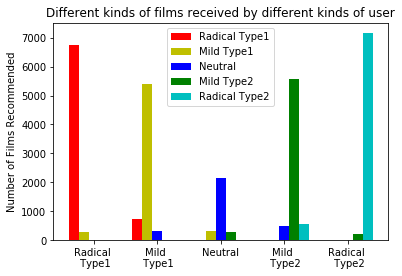

In [62]:
plot_filter_bubble(rec)

In [63]:
# NUM_STEPS x (NUM_USERS * NUM_RECS) matrix of recommended filmIDs
flattened_rec_filmIDs_over_time = np.array([x.flatten() for x in recommended_filmIDs_over_time])
# NUM_STEPS x (NUM_USERS * NUM_RECS) x NUM_GENRES matrix of recommeneded film genre values
flattened_rec_film_genres_over_time = np.array([
    [films[int(filmID)][:NUM_GENRES] for filmID in step_filmIDs]
    for step_filmIDs in flattened_rec_filmIDs_over_time
])
print(flattened_rec_filmIDs_over_time.shape)
print(flattened_rec_film_genres_over_time.shape)

(1134, 30200)
(1134, 30200, 2)


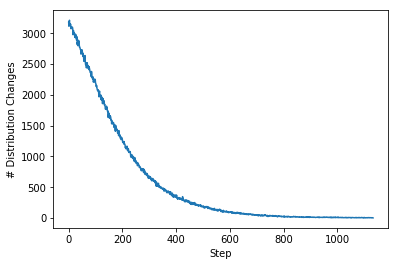

In [64]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()

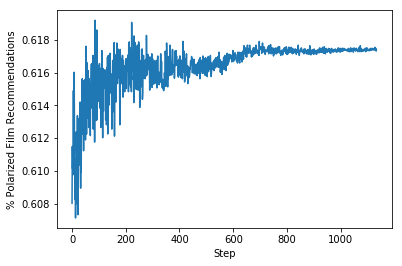

In [65]:
# A film is considered "polarized" if its highest
# film genre value is above this threshold
POLARIZED_FILM_THRESHOLD = 0.7

def get_num_polarized_recs(step_rec_film_genres):
    is_polarized = np.apply_along_axis(lambda x: max(x) > POLARIZED_FILM_THRESHOLD, 1, step_rec_film_genres)
    return sum(is_polarized) / len(step_rec_film_genres)

# Plot the percentage of recommended films that are polarized over time
percent_polarized_recs_over_time = [get_num_polarized_recs(x) for x in flattened_rec_film_genres_over_time]
plt.plot(percent_polarized_recs_over_time)
plt.xlabel("Step")
plt.ylabel("% Polarized Film Recommendations")
plt.show()

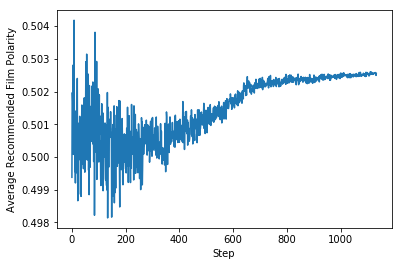

In [66]:
def get_film_polarity(film_genre_vals):
    max_val = max(film_genre_vals)
    return 1.0 * sum([max_val - val for val in film_genre_vals]) / (len(film_genre_vals) - 1)

def get_avg_film_polarity(step_rec_film_genres):
    return np.mean(np.apply_along_axis(lambda x: get_film_polarity(x), 1, step_rec_film_genres), axis=0)

# Plot the average polarity of the film recommendations over time
# Polarity is defined here as the average difference between the
# maximum genre value and the other genre values for a film
avg_rec_film_polarity_over_time = [get_avg_film_polarity(x) for x in flattened_rec_film_genres_over_time]
plt.plot(avg_rec_film_polarity_over_time)
plt.xlabel("Step")
plt.ylabel("Average Recommended Film Polarity")
plt.show()

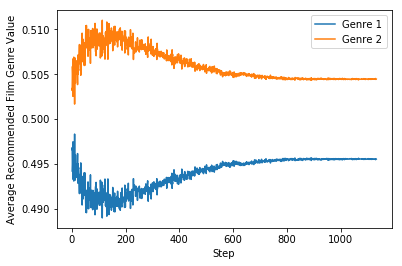

In [67]:
def get_avg_genre_values(step_rec_film_genres):
    return np.mean(step_rec_film_genres, axis=0)

# Plot the distribution of recommended film genres over time
avg_genre_values_over_time = np.array([get_avg_genre_values(x) for x in flattened_rec_film_genres_over_time])
for genre in range(NUM_GENRES):
    plt.plot(avg_genre_values_over_time[:,genre], label="Genre %d" % (genre+1))
plt.xlabel("Step")
plt.ylabel("Average Recommended Film Genre Value")
plt.legend()
plt.show()

### Observations:
Note that the higher the `COMPATIBILITY_RATING_STRENGTH`, the greater the difference between the average rating and the film quality, as expected. In general, the average rating should be higher than the film quality, because films will be recommended to users that the algorithm predicts will like it. An average rating that is lower the film quality suggests that the recommender made poor decisions when recommending that film to users.

Also note that higher quality films have more ratings, as they are recommended to more people.

In [68]:
def display_ratings_stats(filmID):
    film_quality = films[filmID][QUALITY_PROP_IDX]
    film_ratings = ratings_T[filmID]
    film_ratings = film_ratings[film_ratings.nonzero()]
    print("Film Matrix: " + str(films[filmID]))
    print("Film Quality: " + str(film_quality))
    print("Average Rating: " + str(film_ratings.mean()))
    display(film_ratings)

# Print some stats about the film ratings
ratings_T = ratings.T
mean_ratings = np.true_divide(ratings_T.sum(1),(ratings_T!=0).sum(1))
print("Sample Film\n-----------\n")
display_ratings_stats(0)
print("\n\nHighest Rated Film\n------------------\n")
display_ratings_stats(np.argmax(mean_ratings))
print("\nLowest Rated Film\n-----------------\n")
display_ratings_stats(np.argmin(mean_ratings))

Sample Film
-----------

Film Matrix: [0.68515902 0.31484098 1.83444931]
Film Quality: 1.8344493133072495
Average Rating: 2.058530510585305


array([2., 3., 3., 3., 3., 2., 2., 2., 1., 2., 2., 3., 2., 2., 3., 2., 3.,
       2., 3., 2., 3., 2., 3., 3., 2., 2., 2., 3., 2., 1., 2., 3., 1., 1.,
       1., 1., 2., 3., 2., 1., 1., 1., 2., 1., 3., 3., 2., 2., 2., 2., 2.,
       1., 1., 2., 1., 2., 2., 3., 1., 2., 2., 3., 2., 2., 1., 3., 2., 2.,
       3., 2., 2., 1., 2., 3., 3., 2., 2., 1., 1., 1., 1., 2., 2., 1., 3.,
       2., 2., 1., 3., 3., 2., 3., 2., 2., 2., 2., 2., 3., 3., 3., 2., 2.,
       1., 2., 2., 2., 1., 2., 2., 1., 2., 1., 2., 2., 2., 1., 2., 2., 1.,
       1., 2., 2., 2., 3., 2., 2., 2., 2., 2., 3., 2., 1., 2., 1., 2., 1.,
       3., 2., 2., 1., 2., 2., 1., 3., 2., 2., 3., 2., 2., 1., 2., 2., 1.,
       2., 1., 2., 1., 1., 1., 2., 2., 3., 1., 2., 2., 3., 1., 2., 2., 2.,
       3., 2., 3., 3., 3., 3., 2., 2., 1., 2., 2., 3., 2., 2., 2., 1., 1.,
       3., 1., 2., 2., 2., 2., 2., 3., 1., 2., 2., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 2., 3., 3., 2., 2., 2., 3., 2., 2., 3., 1., 3.,
       2., 2., 2., 2., 3.



Highest Rated Film
------------------

Film Matrix: [0.58757553 0.41242447 3.74730414]
Film Quality: 3.7473041426683347
Average Rating: 4.096018735362998


array([4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 3., 5., 4., 3., 5., 4., 4., 5., 4., 4., 5., 4., 5., 4., 5.,
       4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 5., 4., 4., 4., 3., 4., 3.,
       4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 3., 5., 3., 5., 4., 4.,
       5., 4., 5., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4.,
       4., 3., 5., 4., 3., 5., 4., 4., 5., 4., 5., 4., 4., 4., 3., 4., 4.,
       3., 5., 3., 4., 4., 3., 5., 4., 4., 4., 3., 3., 3., 5., 4., 4., 4.,
       4., 4., 5., 4., 3., 4., 3., 5., 3., 4., 3., 3., 4., 4., 4., 4., 3.,
       5., 4., 4., 5., 3., 5., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       3., 3., 4., 4., 4., 4., 5., 3., 5., 3., 4., 4., 4., 3., 3., 4., 3.,
       5., 5., 4., 5., 5., 4., 4., 3., 4., 3., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 5., 4., 3., 4.,
       3., 4., 4., 3., 4.


Lowest Rated Film
-----------------

Film Matrix: [0.02224737 0.97775263 1.30367494]
Film Quality: 1.3036749403795
Average Rating: 1.48125


array([2., 2., 1., 2., 2., 1., 1., 1., 2., 1., 2., 1., 2., 2., 1., 2., 1.,
       1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 2., 2.,
       1., 2., 2., 2., 2., 2., 1., 1., 2., 2., 1., 2., 1., 2., 2., 1., 1.,
       1., 1., 2., 2., 1., 2., 2., 1., 2., 1., 1., 2., 2., 1., 2., 2., 1.,
       2., 1., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2.,
       1., 2., 2., 1., 2., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1.,
       2., 2., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
       2., 2., 1., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 1., 1., 2., 2., 1., 1., 1., 1., 2., 1., 2., 2., 1., 1.,
       1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 2., 1.,
       2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 2., 2., 2., 2., 1., 2., 2.,
       2., 2., 2., 2., 2., 1., 1., 1., 1., 2., 2., 1., 2., 2., 2., 2., 1.,
       1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 1., 2., 2.,
       2., 1., 2., 2., 1.

In [69]:
sorted_movies = np.argsort(-mean_ratings)

for i in range(10):
    display_ratings_stats(sorted_movies[i])

Film Matrix: [0.58757553 0.41242447 3.74730414]
Film Quality: 3.7473041426683347
Average Rating: 4.096018735362998


array([4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 4., 3., 5., 4., 3., 5., 4., 4., 5., 4., 4., 5., 4., 5., 4., 5.,
       4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 5., 4., 4., 4., 3., 4., 3.,
       4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 3., 5., 3., 5., 4., 4.,
       5., 4., 5., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4.,
       4., 3., 5., 4., 3., 5., 4., 4., 5., 4., 5., 4., 4., 4., 3., 4., 4.,
       3., 5., 3., 4., 4., 3., 5., 4., 4., 4., 3., 3., 3., 5., 4., 4., 4.,
       4., 4., 5., 4., 3., 4., 3., 5., 3., 4., 3., 3., 4., 4., 4., 4., 3.,
       5., 4., 4., 5., 3., 5., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       3., 3., 4., 4., 4., 4., 5., 3., 5., 3., 4., 4., 4., 3., 3., 4., 3.,
       5., 5., 4., 5., 5., 4., 4., 3., 4., 3., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 3., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 5., 4., 3., 4.,
       3., 4., 4., 3., 4.

Film Matrix: [0.43998387 0.56001613 3.74438791]
Film Quality: 3.744387906831693
Average Rating: 4.073817762399077


array([4., 4., 4., 4., 4., 4., 4., 5., 4., 5., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 5., 4., 4., 4., 4., 3., 3., 4., 4., 3., 4.,
       3., 4., 4., 4., 4., 4., 3., 4., 5., 3., 4., 4., 5., 5., 4., 4., 4.,
       4., 5., 5., 5., 4., 5., 5., 5., 3., 4., 5., 5., 4., 4., 5., 5., 4.,
       4., 5., 3., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 3., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 4., 4., 3., 3., 4., 4., 4., 3., 4., 4., 4., 4., 5.,
       4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4.,
       4., 3., 5., 5., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 3., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 5., 4., 3., 4., 3., 5., 4., 3., 4., 4.,
       4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4.,
       4., 3., 5., 5., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4.,
       3., 4., 4., 5., 4., 4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 5., 3.,
       4., 5., 5., 4., 3.

Film Matrix: [0.53364905 0.46635095 3.72775386]
Film Quality: 3.727753859702942
Average Rating: 4.0458823529411765


array([4., 4., 4., 5., 3., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 5., 4., 5., 3., 5., 5., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 4., 5., 5.,
       3., 4., 4., 4., 4., 4., 4., 3., 5., 4., 4., 4., 3., 4., 4., 4., 5.,
       4., 4., 3., 4., 5., 4., 4., 5., 4., 4., 5., 4., 5., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 3., 4., 4., 3., 4., 4., 5., 4., 5., 5., 4.,
       3., 4., 5., 3., 4., 4., 4., 4., 4., 3., 4., 4., 5., 4., 3., 4., 5.,
       4., 4., 4., 5., 4., 3., 3., 4., 4., 4., 4., 5., 4., 3., 4., 4., 4.,
       4., 5., 4., 3., 5., 4., 4., 4., 3., 4., 4., 3., 4., 5., 3., 4., 4.,
       4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 3.,
       5., 5., 4., 4., 5., 4., 4., 4., 4., 3., 4., 4., 4., 5., 4., 3., 5.,
       4., 4., 4., 4., 5., 4., 4., 5., 4., 3., 3., 4., 3., 5., 3., 4., 4.,
       4., 4., 4., 5., 4., 5., 3., 5., 3., 4., 4., 3., 4., 4., 4., 4., 4.,
       5., 4., 5., 4., 4.

Film Matrix: [0.39311965 0.60688035 3.73466259]
Film Quality: 3.7346625935227102
Average Rating: 4.038551401869159


array([4., 4., 4., 3., 4., 4., 4., 4., 4., 5., 4., 3., 4., 4., 4., 4., 4.,
       3., 4., 5., 4., 4., 3., 5., 4., 4., 5., 4., 4., 3., 3., 4., 4., 4.,
       5., 4., 4., 4., 5., 4., 5., 5., 4., 3., 4., 4., 4., 3., 4., 4., 4.,
       5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 5.,
       4., 4., 4., 3., 4., 4., 4., 5., 4., 4., 5., 5., 3., 4., 5., 4., 4.,
       3., 4., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 3., 4., 4.,
       4., 4., 4., 5., 4., 3., 5., 4., 5., 4., 5., 4., 4., 4., 5., 5., 4.,
       3., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4.,
       5., 4., 3., 4., 5., 4., 4., 3., 3., 4., 4., 4., 4., 5., 5., 4., 4.,
       3., 4., 4., 3., 4., 4., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 3., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4.,
       3., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 3., 4., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 5., 5., 3., 4., 3., 5., 4., 5., 3., 4., 4., 4.,
       4., 5., 4., 4., 4.

Film Matrix: [0.56264058 0.43735942 3.73504071]
Film Quality: 3.7350407113699
Average Rating: 4.0299760191846525


array([4., 5., 3., 5., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 5., 4., 4., 4., 5., 4., 4., 3., 5., 5., 4., 4., 5., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 5., 4., 4., 3.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 5., 5., 4., 3., 4., 4., 4.,
       5., 3., 4., 3., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 5., 5., 4., 4., 4., 4., 4., 5., 4.,
       4., 4., 5., 3., 4., 4., 4., 4., 3., 3., 4., 5., 5., 4., 4., 5., 4.,
       4., 5., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 5., 5., 5., 4., 4., 4., 4., 4., 3., 4., 4.,
       3., 3., 4., 4., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 5., 3.,
       4., 4., 5., 4., 5., 4., 4., 5., 4., 3., 3., 4., 4., 3., 3., 4., 4.,
       4., 4., 4., 4., 5., 5., 3., 4., 4., 3., 4., 3., 4., 4., 3., 5., 4.,
       3., 4., 4., 5., 5., 4., 4., 5., 4., 4., 4., 3., 4., 4., 3., 5., 4.,
       4., 5., 4., 3., 4.

Film Matrix: [0.41083738 0.58916262 3.74646075]
Film Quality: 3.7464607453157033
Average Rating: 4.026178010471204


array([4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 3., 3., 3., 4., 3., 4.,
       5., 4., 5., 4., 4., 5., 3., 4., 4., 5., 5., 4., 4., 4., 5., 4., 4.,
       4., 4., 5., 5., 4., 3., 5., 4., 4., 5., 4., 3., 5., 3., 5., 5., 4.,
       4., 4., 5., 5., 4., 3., 3., 4., 4., 3., 3., 4., 3., 4., 4., 3., 4.,
       4., 3., 4., 4., 4., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 4., 4.,
       4., 5., 5., 5., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3., 4., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 3., 5., 4., 5., 4.,
       4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4.,
       4., 5., 4., 3., 4., 4., 4., 4., 3., 5., 4., 4., 5., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 5., 4., 5., 3., 4., 3., 4., 4., 5., 3., 4., 4.,
       4., 3., 4., 4., 4., 4., 3., 4., 4., 3., 4., 4., 3., 4., 4., 3., 4.,
       4., 4., 4., 3., 5., 4., 4., 4., 5., 4., 4., 4., 3., 5., 3., 5., 4.,
       5., 4., 3., 4., 3., 4., 4., 4., 4., 4., 3., 4., 5., 4., 4., 4., 4.,
       5., 3., 5., 3., 3.

Film Matrix: [0.57189032 0.42810968 3.73136161]
Film Quality: 3.731361606663573
Average Rating: 4.02477183833116


array([4., 4., 4., 3., 4., 5., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4.,
       5., 4., 4., 4., 4., 5., 5., 4., 4., 3., 3., 4., 5., 5., 4., 4., 3.,
       4., 5., 4., 5., 4., 5., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 5.,
       4., 4., 5., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 5., 4., 3., 4., 4.,
       4., 4., 4., 4., 4., 3., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 5., 4., 4., 3., 4., 5., 4., 4., 4., 4., 4., 4., 3., 3., 4.,
       4., 4., 4., 4., 3., 5., 5., 4., 4., 4., 3., 5., 4., 4., 4., 4., 4.,
       5., 4., 3., 3., 5., 4., 4., 4., 3., 4., 3., 3., 4., 5., 4., 4., 4.,
       3., 4., 5., 3., 4., 4., 3., 4., 4., 4., 4., 5., 3., 4., 4., 3., 4.,
       5., 3., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4.,
       4., 5., 4., 3., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 3., 3., 4., 4., 3., 4., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 3., 4., 4.

Film Matrix: [0.5887716  0.4112284  3.71751927]
Film Quality: 3.717519270229037
Average Rating: 4.024110218140069


array([4., 4., 3., 5., 4., 4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 5., 4.,
       4., 4., 3., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 3.,
       4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3., 3., 4., 4., 4., 4.,
       3., 5., 4., 4., 5., 3., 4., 4., 4., 4., 4., 4., 5., 3., 4., 5., 5.,
       4., 4., 3., 3., 3., 4., 4., 5., 5., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 4., 4., 4., 3., 4., 3., 4., 5., 4., 4., 4., 4., 4.,
       4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 3., 4.,
       4., 3., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3., 4., 4., 3., 4.,
       4., 4., 4., 4., 4., 5., 4., 3., 3., 4., 5., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 3., 3., 4., 4., 5., 5., 4., 4., 4., 3., 3., 4., 4.,
       4., 3., 3., 4., 4., 3., 4., 3., 4., 3., 5., 4., 3., 5., 4., 4., 4.,
       3., 5., 4., 4., 4., 4., 4., 5., 5., 4., 4., 3., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 3., 3., 5., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 5., 4.

Film Matrix: [0.50284341 0.49715659 3.74252081]
Film Quality: 3.7425208110240846
Average Rating: 4.023170731707317


array([4., 5., 4., 5., 4., 4., 4., 5., 4., 4., 5., 5., 3., 5., 3., 3., 4.,
       3., 4., 4., 5., 4., 4., 3., 3., 5., 4., 4., 3., 4., 4., 4., 4., 4.,
       5., 5., 4., 4., 4., 4., 5., 3., 5., 4., 4., 4., 5., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 3., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 3., 3., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 3., 4., 4., 4., 4., 5., 4., 5., 4., 5., 5., 4., 4., 4., 4.,
       4., 4., 5., 4., 5., 3., 3., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5.,
       4., 3., 3., 4., 3., 4., 4., 5., 5., 3., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 5., 4., 3., 3., 3., 3., 3., 5., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 5., 4., 4., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 3., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 3., 5.

Film Matrix: [0.59922724 0.40077276 3.70900372]
Film Quality: 3.7090037238795732
Average Rating: 4.019277108433735


array([3., 4., 3., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 3.,
       4., 4., 4., 4., 4., 3., 4., 4., 4., 5., 4., 3., 4., 4., 4., 3., 5.,
       4., 4., 4., 5., 4., 4., 4., 4., 5., 5., 3., 4., 4., 4., 4., 4., 5.,
       4., 4., 3., 3., 4., 5., 3., 4., 4., 5., 4., 4., 4., 5., 5., 3., 4.,
       4., 4., 4., 5., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 5., 4., 5.,
       4., 4., 3., 4., 5., 4., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 5., 4., 4., 4., 5., 3., 3., 4., 3., 4., 4., 4., 4., 5.,
       3., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 3., 5., 4., 5., 4., 4., 3., 3., 4., 5., 4.,
       4., 4., 4., 5., 4., 4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 3., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 3., 3., 4., 3., 4., 5., 5., 3., 4., 5., 4., 3., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 5., 4., 5., 4.,
       5., 4., 4., 4., 4.